In [1]:
import distribution_test as dt
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import matplotlib as mpl
import numpy as np
import pandas as pd
from scipy.spatial import cKDTree
from sklearn.preprocessing import StandardScaler
from glob import glob
from tqdm import tqdm

HSC_color = 'grey'
HSC_TNG50_color = 'bisque'
HSC_TNG100_color = 'aqua'
TNG50_color = 'orange'
TNG100_color = 'blue'

palette = {'HSC_TNG50': HSC_TNG50_color,
           'HSC_TNG100': HSC_TNG100_color,
           'TNG50': TNG50_color,
           'TNG100': TNG100_color,
           'HSC': HSC_color,
           'TNG50_TNG100': 'green'}

In [10]:
#I recopy the matching algorithm here because im not able to make the import working...
def get_matched_masks(source, target, source_label, target_label):
    '''
    Match the set given by source to the set given by target. 
    Returns the masks of source and target datasets such that the distribution for the given fields are identical
    '''
        
    MATCHING_UNCERTAINTIES = [0.01, 0.1, 5]
        
    #Get random
    rng = np.random.default_rng(0)
        
    #Ensure that we are dealing with numpy arrays
    source = np.array(source)
    target = np.array(target)
        
    #Set of already used indexes
    unused_source_mask = np.ones(source.shape[0])
        
    #Output list containing the matched target sets to keep record of the matched pairs
    matched_source_sets = np.array(['']*source.shape[0], dtype=object)
    matched_target_sets = np.array(['']*target.shape[0], dtype=object)
        
    #Output mask to remove targets which have no partner
    matched_source_mask = np.zeros(source.shape[0])
    matched_target_mask = np.zeros(target.shape[0])

    #Prepare indexes to walk randomly through the target set
    random_indexes = np.arange(target.shape[0])
    rng.shuffle(random_indexes)
        
    for i in tqdm(random_indexes):
            
        x = target[i]
            
        within_box = np.all(np.abs(source - x) <= MATCHING_UNCERTAINTIES, axis=1)
        within_box = np.logical_and(unused_source_mask, within_box)
        within_box_index = np.argwhere(within_box)
            
        if len(within_box_index) > 0:
            index = int(rng.choice(within_box_index)[0])
            matched_source_sets[index] = target_label[i]
            matched_target_sets[i] = source_label[index]
            unused_source_mask[index]= False
            matched_source_mask[index] = True 
            matched_target_mask[i] = True
        
    #To boolean numpy array
    matched_source_mask = np.array(matched_source_mask, dtype=bool)
    matched_target_mask = np.array(matched_target_mask, dtype=bool)
        
    #Print numer of matched galaxies
    num_matched = str(np.sum(matched_target_mask))
    num_target = str(len(matched_target_mask))
    print("Number of matched galaxies: " + num_matched + " / " + num_target)
        
    return matched_source_mask, matched_target_mask, matched_source_sets, matched_target_sets

In [3]:
def load_representation(path):
    with open(path, 'rb') as f:
        rep = np.load(f)

    scaler = StandardScaler()
    scaler.fit(rep)
    rep = scaler.transform(rep)
    
    return rep


optuna_files = glob('../../postprocessing/optuna/*')
representation_path = '../../postprocessing/representation.npy'

rep = load_representation(representation_path)
df = pd.read_csv('../../dataset/m_test.csv')

HSC_arcsec_per_pixel = 0.168
df["petro_90_light"] = df['petro_90_light'].multiply(HSC_arcsec_per_pixel)

optuna_rep = []

for path in tqdm(optuna_files):
    optuna_rep.append(load_representation(path))


100%|██████████| 15/15 [00:08<00:00,  1.85it/s]


In the first Section we split every dataset into 2 subsets to investigate the distribution of the distances and to get the scaling factor

In [16]:
indices_HSC_TNG100 = np.argwhere((df['matched_set'] == 'HSC_TNG100').to_numpy())[:,0]
indices_HSC_TNG50 = np.argwhere((df['matched_set'] == 'HSC_TNG50').to_numpy())[:,0]
indices_TNG100 = np.argwhere((df['dataset'] == 'HSC_TNG100').to_numpy())[:,0]
indices_TNG50 = np.argwhere((df['dataset'] == 'HSC_TNG50').to_numpy())[:,0]

np.random.shuffle(indices_HSC_TNG100)
np.random.shuffle(indices_HSC_TNG50)
np.random.shuffle(indices_TNG100)
np.random.shuffle(indices_TNG50)

split_indices_HSC_TNG100 = np.array_split(indices_HSC_TNG100, 2)
split_indices_HSC_TNG50 = np.array_split(indices_HSC_TNG50, 2)
split_indices_TNG100 = np.array_split(indices_TNG100, 2)
split_indices_TNG50 = np.array_split(indices_TNG50, 2)

def split(rep):
    #TNG100 - HSC
    x_list = [rep[split_indices_HSC_TNG100[0]], rep[split_indices_HSC_TNG100[1]], rep[split_indices_TNG100[0]], rep[split_indices_TNG100[1]]]
    df_list = [df.iloc[split_indices_HSC_TNG100[0]], df.iloc[split_indices_HSC_TNG100[1]], df.iloc[split_indices_TNG100[0]], df.iloc[split_indices_TNG100[1]]]
    x_list, _ = dt.DistributionTest.reshape_inputs(x_list,df_list)
    rep_HSC_TNG100_0 = x_list[0]
    rep_HSC_TNG100_1 = x_list[1]
    rep_TNG100_0 = x_list[2]
    rep_TNG100_1 = x_list[3]

    #TNG50 - HSC
    x_list = [rep[split_indices_HSC_TNG50[0]], rep[split_indices_HSC_TNG50[1]], rep[split_indices_TNG50[0]], rep[split_indices_TNG50[1]]]
    df_list = [df.iloc[split_indices_HSC_TNG50[0]], df.iloc[split_indices_HSC_TNG50[1]], df.iloc[split_indices_TNG50[0]], df.iloc[split_indices_TNG50[1]]]

    x_list, _ = dt.DistributionTest.reshape_inputs(x_list,df_list)
    rep_HSC_TNG50_0 = x_list[0]
    rep_HSC_TNG50_1 = x_list[1]
    rep_TNG50_0 = x_list[2]
    rep_TNG50_1 = x_list[3]

    #TNG50 - TNG100 with additional matching (we originaly matched them only to HSC)
    x_list = [rep[split_indices_TNG50[0]], rep[split_indices_TNG50[1]], rep[split_indices_TNG100[0]], rep[split_indices_TNG100[1]]]
    df_list = [df.iloc[split_indices_TNG50[0]], df.iloc[split_indices_TNG50[1]], df.iloc[split_indices_TNG100[0]], df.iloc[split_indices_TNG100[1]]]

    x_list, df_list = dt.DistributionTest.reshape_inputs(x_list,df_list)
    
    fields = ['z', 'i_band_mag_dust_apparent', 'petro_90_light']
    
    df_TNG50_TNG100_0 = df_list[0]
    df_TNG50_TNG100_1 = df_list[1]
    df_TNG100_TNG50_0 = df_list[2]
    df_TNG100_TNG50_1 = df_list[3]
    
    null = [np.nan]*len(df_TNG100_TNG50_0)
    mask_1, mask_2, _, _ = get_matched_masks(df_TNG100_TNG50_0[fields], df_TNG50_TNG100_0[fields], null, null)
    rep_TNG50_TNG100_0 = x_list[0][mask_2]
    rep_TNG100_TNG50_0 = x_list[2][mask_1]
    
    null = [np.nan]*len(df_TNG100_TNG50_1)
    mask_1, mask_2, _, _ = get_matched_masks(df_TNG100_TNG50_1[fields], df_TNG50_TNG100_1[fields], null, null)
    rep_TNG50_TNG100_1 = x_list[1][mask_2]
    rep_TNG100_TNG50_1 = x_list[3][mask_1]
    
    return (rep_HSC_TNG100_0,
            rep_HSC_TNG100_1,
            rep_TNG100_0,
            rep_TNG100_1,
            rep_HSC_TNG50_0,
            rep_HSC_TNG50_1,
            rep_TNG50_0,
            rep_TNG50_1,
            rep_TNG50_TNG100_0,
            rep_TNG50_TNG100_1,
            rep_TNG100_TNG50_0,
            rep_TNG100_TNG50_1)
            

rep_split = split(rep)

rep_optuna_split = []
for r in tqdm(optuna_rep):
    rep_optuna_split.append(split(r))

100%|██████████| 2860/2860 [00:00<00:00, 15884.63it/s]


Number of matched galaxies: 1782 / 2860


100%|██████████| 2860/2860 [00:00<00:00, 15749.95it/s]


Number of matched galaxies: 1847 / 2860


100%|██████████| 2860/2860 [00:00<00:00, 15433.29it/s]


Number of matched galaxies: 1782 / 2860



  7%|▋         | 1/15 [00:00<00:06,  2.32it/s]

Number of matched galaxies: 1847 / 2860



100%|██████████| 2860/2860 [00:00<00:00, 15430.99it/s]


Number of matched galaxies: 1782 / 2860



 13%|█▎        | 2/15 [00:00<00:05,  2.37it/s]

Number of matched galaxies: 1847 / 2860



100%|██████████| 2860/2860 [00:00<00:00, 15570.73it/s]


Number of matched galaxies: 1782 / 2860



 20%|██        | 3/15 [00:01<00:05,  2.39it/s]

Number of matched galaxies: 1847 / 2860



100%|██████████| 2860/2860 [00:00<00:00, 15431.54it/s]


Number of matched galaxies: 1782 / 2860



 27%|██▋       | 4/15 [00:01<00:04,  2.39it/s]

Number of matched galaxies: 1847 / 2860



100%|██████████| 2860/2860 [00:00<00:00, 15520.31it/s]


Number of matched galaxies: 1782 / 2860



 33%|███▎      | 5/15 [00:02<00:04,  2.39it/s]

Number of matched galaxies: 1847 / 2860



100%|██████████| 2860/2860 [00:00<00:00, 15782.37it/s]


Number of matched galaxies: 1782 / 2860



 40%|████      | 6/15 [00:02<00:03,  2.40it/s]

Number of matched galaxies: 1847 / 2860



100%|██████████| 2860/2860 [00:00<00:00, 15796.34it/s]


Number of matched galaxies: 1782 / 2860



 47%|████▋     | 7/15 [00:02<00:03,  2.41it/s]

Number of matched galaxies: 1847 / 2860



100%|██████████| 2860/2860 [00:00<00:00, 15815.10it/s]


Number of matched galaxies: 1782 / 2860



 53%|█████▎    | 8/15 [00:03<00:02,  2.42it/s]

Number of matched galaxies: 1847 / 2860



100%|██████████| 2860/2860 [00:00<00:00, 15600.14it/s]


Number of matched galaxies: 1782 / 2860



 60%|██████    | 9/15 [00:03<00:02,  2.41it/s]

Number of matched galaxies: 1847 / 2860



100%|██████████| 2860/2860 [00:00<00:00, 15480.33it/s]


Number of matched galaxies: 1782 / 2860



 67%|██████▋   | 10/15 [00:04<00:02,  2.42it/s]

Number of matched galaxies: 1847 / 2860



100%|██████████| 2860/2860 [00:00<00:00, 15337.49it/s]


Number of matched galaxies: 1782 / 2860



 73%|███████▎  | 11/15 [00:04<00:01,  2.41it/s]

Number of matched galaxies: 1847 / 2860



100%|██████████| 2860/2860 [00:00<00:00, 15640.23it/s]


Number of matched galaxies: 1782 / 2860



 80%|████████  | 12/15 [00:04<00:01,  2.41it/s]

Number of matched galaxies: 1847 / 2860



100%|██████████| 2860/2860 [00:00<00:00, 15646.22it/s]


Number of matched galaxies: 1782 / 2860



 87%|████████▋ | 13/15 [00:05<00:00,  2.41it/s]

Number of matched galaxies: 1847 / 2860



100%|██████████| 2860/2860 [00:00<00:00, 15546.72it/s]


Number of matched galaxies: 1782 / 2860



 93%|█████████▎| 14/15 [00:05<00:00,  2.41it/s]

Number of matched galaxies: 1847 / 2860



100%|██████████| 2860/2860 [00:00<00:00, 15628.37it/s]


Number of matched galaxies: 1782 / 2860



100%|██████████| 15/15 [00:06<00:00,  2.40it/s]

Number of matched galaxies: 1847 / 2860


In [17]:
def rep2score(rep_split, n):
    
    (rep_HSC_TNG100_0,
     rep_HSC_TNG100_1,
     rep_TNG100_0,
     rep_TNG100_1,
     rep_HSC_TNG50_0,
     rep_HSC_TNG50_1,
     rep_TNG50_0,
     rep_TNG50_1,
     rep_TNG50_TNG100_0,
     rep_TNG50_TNG100_1,
     rep_TNG100_TNG50_0,
     rep_TNG100_TNG50_1) = rep_split
    
    
    mnnd_TNG100 = dt.MeanNormalizedNeighborDistance(rep_TNG100_0, n_neighbor=n, p=1)
    score_TNG100_TNG100 = mnnd_TNG100.get_normalized_neighbor_distances(rep_TNG100_1)
    score_TNG100_HSC = mnnd_TNG100.get_normalized_neighbor_distances(rep_HSC_TNG100_0)

    mnnd_TNG100 = dt.MeanNormalizedNeighborDistance(rep_TNG100_TNG50_0, n_neighbor=n, p=1)
    score_TNG100_TNG50 = mnnd_TNG100.get_normalized_neighbor_distances(rep_TNG50_TNG100_0)

    mnnd_TNG50 = dt.MeanNormalizedNeighborDistance(rep_TNG50_TNG100_0, n_neighbor=n, p=1)
    score_TNG50_TNG100 = mnnd_TNG50.get_normalized_neighbor_distances(rep_TNG100_TNG50_0)

    mnnd_TNG50 = dt.MeanNormalizedNeighborDistance(rep_TNG50_0, n_neighbor=n, p=1)
    score_TNG50_HSC = mnnd_TNG50.get_normalized_neighbor_distances(rep_HSC_TNG50_0)
    score_TNG50_TNG50 = mnnd_TNG50.get_normalized_neighbor_distances(rep_TNG50_1)

    mnnd_HSC = dt.MeanNormalizedNeighborDistance(rep_HSC_TNG100_0, n_neighbor=n, p=1)
    score_HSC_HSC = mnnd_HSC.get_normalized_neighbor_distances(rep_HSC_TNG100_1)
    score_HSC_TNG100 = mnnd_HSC.get_normalized_neighbor_distances(rep_TNG100_0)

    mnnd_HSC = dt.MeanNormalizedNeighborDistance(rep_HSC_TNG50_0, n_neighbor=n, p=1)
    score_HSC_TNG50 = mnnd_HSC.get_normalized_neighbor_distances(rep_TNG50_0)
    
    return (score_TNG100_TNG100,
            score_TNG100_HSC,
            score_TNG100_TNG50,
            score_TNG50_TNG100,
            score_TNG50_HSC,
            score_TNG50_TNG50,
            score_HSC_HSC,
            score_HSC_TNG100,
            score_HSC_TNG50)

score = rep2score(rep_split, n=8)
score_4 = rep2score(rep_split, n=4)
score_16 = rep2score(rep_split, n=16)
score_32 = rep2score(rep_split, n=32)

score_optuna = []
for r in tqdm(rep_optuna_split):
    score_optuna.append(rep2score(r, n=8))

100%|██████████| 15/15 [06:59<00:00, 27.95s/it]


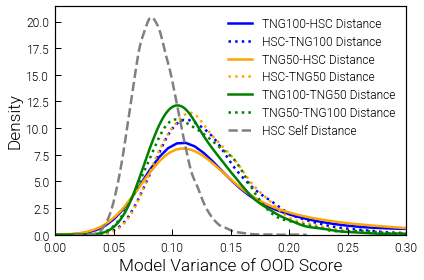

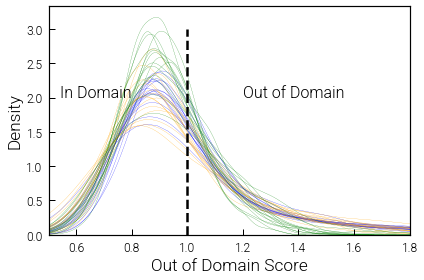

In [23]:
lw = 2.5

sns.kdeplot(x=np.std([s[1]/1.146 for s in score_optuna], axis=0), color=palette['TNG100'], lw=lw)
sns.kdeplot(x=np.std([s[7]/1.146 for s in score_optuna], axis=0), color=palette['TNG100'], linestyle='dotted', lw=lw)
sns.kdeplot(x=np.std([s[4]/1.146 for s in score_optuna], axis=0), color=palette['TNG50'], lw=lw)
sns.kdeplot(x=np.std([s[8]/1.146 for s in score_optuna], axis=0), color=palette['TNG50'], linestyle='dotted', lw=lw)
sns.kdeplot(x=np.std([s[2]/1.146 for s in score_optuna], axis=0), color=palette['TNG50_TNG100'], lw=lw)
sns.kdeplot(x=np.std([s[3]/1.146 for s in score_optuna], axis=0), color=palette['TNG50_TNG100'], linestyle='dotted', lw=lw)
sns.kdeplot(x=np.std([s[6]/1.146 for s in score_optuna], axis=0), color=palette['HSC'], linestyle='dashed', lw=lw)

plt.legend(labels=['TNG100-HSC Distance', 'HSC-TNG100 Distance', 'TNG50-HSC Distance', 'HSC-TNG50 Distance', 'TNG100-TNG50 Distance', 'TNG50-TNG100 Distance', 'HSC Self Distance'])
plt.xlabel('Model Variance of OOD Score')
plt.savefig('../../temp/ood_model_variance.pdf')
plt.xlim(0,0.3)
plt.show()

index_list = [1, 4, 3]
set_list = ['TNG100', 'TNG50', 'TNG50_TNG100']

for i, c in zip(index_list, set_list):
    for s in score_optuna:
        sns.kdeplot(x=s[i]/1.146 , color=palette[c], lw=0.2)
        
plt.xlim(0.5,1.8)
plt.plot([1,1],[0,3],'k--', lw=lw)
plt.text(0.54, 2, 'In Domain', color='k', size=16)
plt.text(1.2, 2, 'Out of Domain', color='k', size=16)
plt.xlabel('Out of Domain Score')
plt.ylabel('Density')
plt.savefig('../../temp/ood_model_variation.pdf')
plt.show()
        

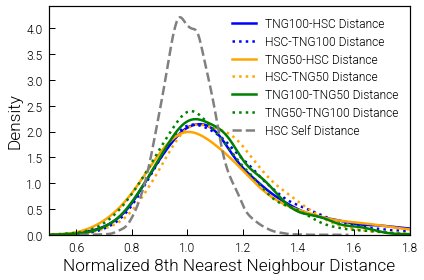

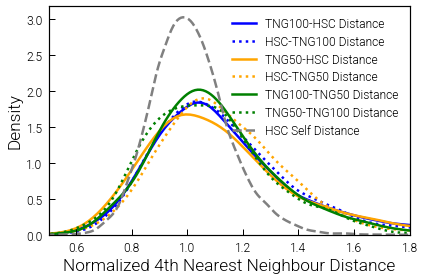

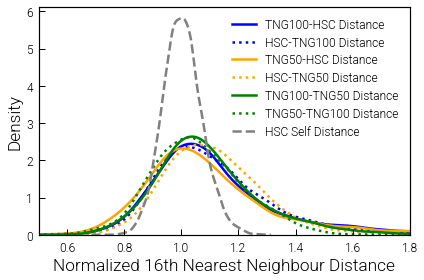

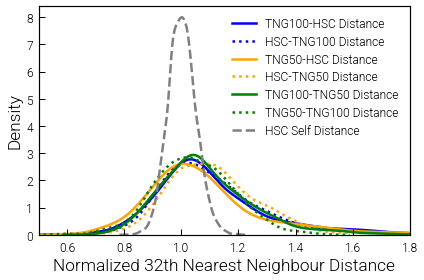

In [24]:
def plot_distances(score, label = 'Normalized 8th Nearest Neighbour Distance', save_path = 'similarity_distribution.pdf'):
    (score_TNG100_TNG100,
     score_TNG100_HSC,
     score_TNG100_TNG50,
     score_TNG50_TNG100,
     score_TNG50_HSC,
     score_TNG50_TNG50,
     score_HSC_HSC,
     score_HSC_TNG100,
     score_HSC_TNG50) = score

    lw = 2.5
    sns.kdeplot(x=score_TNG100_HSC, color=palette['TNG100'], lw=lw)
    sns.kdeplot(x=score_HSC_TNG100, color=palette['TNG100'], linestyle='dotted', lw=lw)
    sns.kdeplot(x=score_TNG50_HSC, color=palette['TNG50'], lw=lw)
    sns.kdeplot(x=score_HSC_TNG50, color=palette['TNG50'], linestyle='dotted', lw=lw)

    sns.kdeplot(x=score_TNG100_TNG50, color=palette['TNG50_TNG100'], lw=lw)
    sns.kdeplot(x=score_TNG50_TNG100, color=palette['TNG50_TNG100'], linestyle='dotted', lw=lw)

    sns.kdeplot(x=score_HSC_HSC, color=palette['HSC'], linestyle='dashed', lw=lw)
    #sns.kdeplot(x=score_TNG100_TNG100, color=palette['HSC'], linestyle='dotted', lw=lw)
    #sns.kdeplot(x=score_TNG50_TNG50, color=palette['HSC'], linestyle='dashdot', lw=lw)


    #plt.legend(labels=['TNG100-HSC Distance', 'HSC-TNG100 Distance', 'TNG50-HSC Distance', 'HSC-TNG50 Distance', 'TNG100-TNG50 Distance', 'TNG50-TNG100 Distance', 'HSC Self Distance','TNG100 Self Distance','TNG50 Self Distance'])
    plt.legend(labels=['TNG100-HSC Distance', 'HSC-TNG100 Distance', 'TNG50-HSC Distance', 'HSC-TNG50 Distance', 'TNG100-TNG50 Distance', 'TNG50-TNG100 Distance', 'HSC Self Distance'])


    plt.xlim(0.5,1.8)
    plt.xlabel(label)
    plt.ylabel('Density')
    plt.savefig('../../temp/' + save_path)
    plt.show()
    
plot_distances(score)
plot_distances(score_4, label = 'Normalized 4th Nearest Neighbour Distance', save_path = 'similarity_distribution_4.pdf')
plot_distances(score_16, label = 'Normalized 16th Nearest Neighbour Distance', save_path = 'similarity_distribution_16.pdf')
plot_distances(score_32, label = 'Normalized 32th Nearest Neighbour Distance', save_path = 'similarity_distribution_32.pdf')
#print('optuna')
#for i in range(len(score_optuna)):
#    plot_distances(score_optuna[i], save_path = 'similarity_distribution_run_%02d.pdf'%(i))

In [21]:
(score_TNG100_TNG100,
 score_TNG100_HSC,
 score_TNG100_TNG50,
 score_TNG50_TNG100,
 score_TNG50_HSC,
 score_TNG50_TNG50,
 score_HSC_HSC,
 score_HSC_TNG100,
 score_HSC_TNG50) = score

factor_TNG100 = np.quantile(score_TNG100_TNG100, 0.95)
factor_TNG50 = np.quantile(score_TNG50_TNG50, 0.95)
factor_HSC = np.quantile(score_HSC_HSC, 0.95)

print(factor_TNG100)
print(factor_TNG50)
print(factor_HSC)

score_TNG100_HSC = score_TNG100_HSC/factor_TNG100
score_HSC_TNG100 = score_HSC_TNG100/factor_HSC
score_TNG50_HSC = score_TNG50_HSC/factor_TNG50
score_HSC_TNG50 = score_HSC_TNG50/factor_HSC

score_TNG100_TNG50 = score_TNG100_TNG50/factor_TNG100
score_TNG50_TNG100 = score_TNG50_TNG100/factor_TNG50
score_HSC_HSC = score_HSC_HSC/factor_HSC

1.1613883679570574
1.179996636109997
1.171744633192971


0.3430169333540469
0.3367251825384496
0.3104895104895105
0.3559440559440559
0.31200897867564537
0.23737373737373738
0.05002330278079851


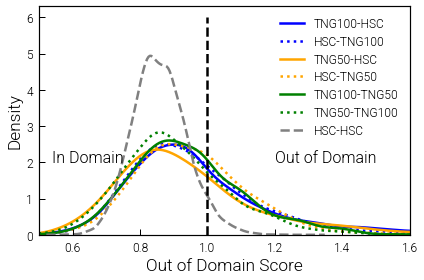

In [22]:
lw = 2.5

sns.kdeplot(x=score_TNG100_HSC, color=palette['TNG100'], lw=lw)
sns.kdeplot(x=score_HSC_TNG100, color=palette['TNG100'], linestyle='dotted', lw=lw)
sns.kdeplot(x=score_TNG50_HSC, color=palette['TNG50'], lw=lw)
sns.kdeplot(x=score_HSC_TNG50, color=palette['TNG50'], linestyle='dotted', lw=lw)
print(np.sum(score_TNG100_HSC>1.0)/len(score_TNG100_HSC))
print(np.sum(score_HSC_TNG100>1.0)/len(score_HSC_TNG100))
print(np.sum(score_TNG50_HSC>1.0)/len(score_TNG50_HSC))
print(np.sum(score_HSC_TNG50>1.0)/len(score_HSC_TNG50))


sns.kdeplot(x=score_TNG100_TNG50, color=palette['TNG50_TNG100'], lw=lw)
sns.kdeplot(x=score_TNG50_TNG100, color=palette['TNG50_TNG100'], linestyle='dotted', lw=lw)
print(np.sum(score_TNG100_TNG50>1.0)/len(score_TNG100_TNG50))
print(np.sum(score_TNG50_TNG100>1.0)/len(score_TNG50_TNG100))

sns.kdeplot(x=score_HSC_HSC, color=palette['HSC'], linestyle='dashed', lw=lw)
print(np.sum(score_HSC_HSC>1.0)/len(score_HSC_HSC))

plt.legend(labels=['TNG100-HSC', 'HSC-TNG100', 'TNG50-HSC', 'HSC-TNG50', 'TNG100-TNG50', 'TNG50-TNG100', 'HSC-HSC'])

plt.plot([1,1],[0,6],'k--', lw=lw)
plt.text(0.54, 2, 'In Domain', color='k', size=16)
plt.text(1.2, 2, 'Out of Domain', color='k', size=16)

plt.xlim(0.5,1.6)
plt.xlabel('Out of Domain Score')
plt.ylabel('Density')
plt.savefig('../../temp/similarity_distribution_scaled.pdf')
plt.show()

In [ ]:
indices_HSC_TNG100 = np.argwhere((df['matched_set'] == 'HSC_TNG100').to_numpy())[:,0]
indices_HSC_TNG50 = np.argwhere((df['matched_set'] == 'HSC_TNG50').to_numpy())[:,0]
indices_TNG100 = np.argwhere((df['dataset'] == 'HSC_TNG100').to_numpy())[:,0]
indices_TNG50 = np.argwhere((df['dataset'] == 'HSC_TNG50').to_numpy())[:,0]

np.random.shuffle(indices_HSC_TNG100)
np.random.shuffle(indices_HSC_TNG50)
np.random.shuffle(indices_TNG100)
np.random.shuffle(indices_TNG50)


#HSC -- TNG100
x_list = [rep[indices_HSC_TNG100], rep[indices_TNG100]]
df_list = [df.iloc[indices_HSC_TNG100], df.iloc[indices_TNG100]]

x_list, df_list = dt.DistributionTest.reshape_inputs(x_list,df_list)

rep_HSC_TNG100 = x_list[0]
rep_TNG100_HSC = x_list[1]
df_HSC_TNG100 = df_list[0]
df_TNG100_HSC = df_list[1]


#HSC -- TNG50
x_list = [rep[indices_HSC_TNG50], rep[indices_TNG50]]
df_list = [df.iloc[indices_HSC_TNG50], df.iloc[indices_TNG50]]

x_list, df_list = dt.DistributionTest.reshape_inputs(x_list,df_list)

rep_HSC_TNG50 = x_list[0]
rep_TNG50_HSC = x_list[1]
df_HSC_TNG50 = df_list[0]
df_TNG50_HSC = df_list[1]


#TNG100 -- TNG50
x_list = [rep[indices_TNG100], rep[indices_TNG50]]
df_list = [df.iloc[indices_TNG100], df.iloc[indices_TNG50]]

x_list, df_list = dt.DistributionTest.reshape_inputs(x_list,df_list)

rep_TNG100_TNG50 = x_list[0]
rep_TNG50_TNG100 = x_list[1]
df_TNG100_TNG50 = df_list[0]
df_TNG50_TNG100 = df_list[1]

assert rep_HSC_TNG50.shape[0] == len(df_HSC_TNG50)
assert rep_HSC_TNG100.shape[0] == len(df_HSC_TNG100)
assert rep_TNG50_HSC.shape[0] == len(df_TNG50_HSC)
assert rep_TNG100_HSC.shape[0] == len(df_TNG100_HSC)
assert rep_TNG50_TNG100.shape[0] == len(df_TNG50_TNG100)
assert rep_TNG100_TNG50.shape[0] == len(df_TNG100_TNG50)

In [ ]:
mnnd_TNG100 = dt.MeanNormalizedNeighborDistance(rep_TNG100_HSC, n_neighbor=8, p=1)
score_TNG100_HSC = mnnd_TNG100.get_normalized_neighbor_distances(rep_HSC_TNG100)/factor_TNG100

mnnd_TNG50 = dt.MeanNormalizedNeighborDistance(rep_TNG50_HSC, n_neighbor=8, p=1)
score_TNG50_HSC = mnnd_TNG50.get_normalized_neighbor_distances(rep_HSC_TNG50)/factor_TNG50

mnnd_HSC = dt.MeanNormalizedNeighborDistance(rep_HSC_TNG100, n_neighbor=8, p=1)
score_HSC_TNG100 = mnnd_HSC.get_normalized_neighbor_distances(rep_TNG100_HSC)/factor_HSC

mnnd_HSC = dt.MeanNormalizedNeighborDistance(rep_HSC_TNG50, n_neighbor=8, p=1)
score_HSC_TNG50 = mnnd_HSC.get_normalized_neighbor_distances(rep_TNG50_HSC)/factor_HSC

In [ ]:
label_TNG =['fraction_disk_stars', 'color',  'mass', 'half_mass_rad_physical', 'asymmetry', 'concentration', 'smoothness', 'sersic_n', 'sersic_rhalf', 'sersic_ellip', 'gini_m20_bulge', 'gini_m20_merger']
label_TNG_human =['Fraction of Disk Stars', 'g-r Color [mag]', 'Stellar Mass [$M_\odot$]', 'Half Mass Radius [kpc]', 'Asymmetry', 'Concentration', 'Smoothness', 'Sersic N', 'Sersic Rhalf', 'Sersic Ellip', 'Gini-M20 Bulge', 'Gini-M20 Merger']

for l, lh in zip(label_TNG, label_TNG_human):
    try:
        
        sns.kdeplot(x=score_TNG100_HSC, y=df_TNG100_HSC[l], levels=5, linewidths=2, color=palette['TNG100'], linestyles='solid')
        
        bin_statistic, bin_edges, binnumber = stats.binned_statistic(score_TNG100_HSC, df_TNG100_HSC[l], statistic=np.nanmedian, bins=10)
        bin_width = (bin_edges[1] - bin_edges[0])
        bin_centers = bin_edges[1:] - bin_width/2
        plt.hlines(bin_statistic, bin_edges[:-1], bin_edges[1:], colors=palette['TNG100'], lw=2)
        
        sns.kdeplot(x=score_TNG50_HSC, y=df_TNG50_HSC[l], levels=5, linewidths=1, color=palette['TNG50'], linestyles='solid')
        bin_statistic, bin_edges, binnumber = stats.binned_statistic(score_TNG50_HSC, df_TNG50_HSC[l], statistic=np.nanmedian, bins=10)
        bin_width = (bin_edges[1] - bin_edges[0])
        bin_centers = bin_edges[1:] - bin_width/2
        plt.hlines(bin_statistic, bin_edges[:-1], bin_edges[1:], colors=palette['TNG50'], lw=2)
        
        y_min = np.nanquantile(df_TNG100_HSC[l], q=0.01)
        y_max = np.nanquantile(df_TNG100_HSC[l], q=0.99)
        
        plt.plot([1,1], [y_min, y_max], 'k--', lw=2)
        
        plt.ylabel(lh)
        plt.xlabel('Out of Domain Score')
        plt.xlim(0.5, 2)
        plt.ylim(y_min, y_max)
        plt.savefig(f'../../temp/similarity_score_{l}.pdf')
        plt.show()
        
    except Exception as e:
        print(e)

In [ ]:
import umap

#Set seed
SEED = 0

#Plot a single UMAP of x with color c
def create_umap(x, n_neighbors=50, min_dist=0.1, n_components=2, metric='euclidean'):
    fit = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=n_components,
        metric=metric,
        densmap=False,
        random_state=SEED
    )
    model = fit.fit(x)
    
    return model

In [ ]:
model = create_umap(rep, n_neighbors=100, min_dist=0.5)
u_TNG100 = model.transform(rep_TNG100_HSC)
u_TNG50 = model.transform(rep_TNG50_HSC)
u_HSC = model.transform(rep_HSC_TNG100)

In [ ]:
u_list = [u_TNG100, u_TNG50, u_HSC]
gridsize_list = [20, 10, 20]
score_list = [score_TNG100_HSC, score_TNG50_HSC, score_HSC_TNG100]
label_list = ['TNG100', 'TNG50', 'HSC']

for u, score, l, g in zip(u_list, score_list, label_list, gridsize_list):
    plt.hexbin(u[:,0],u[:,1],
                   C=score,
                   gridsize=g,
                   mincnt=5,
                   reduce_C_function=np.median)
    sns.kdeplot(x=u_HSC[:,0], y=u_HSC[:,1], levels=[0.2], linewidths=5, color=palette['HSC'], linestyles='dashed')
    sns.kdeplot(x=u_TNG100[:,0], y=u_TNG100[:,1], levels=[0.2], linewidths=5, color=palette['TNG100'], linestyles='dashed')
    sns.kdeplot(x=u_TNG50[:,0], y=u_TNG50[:,1], levels=[0.2], linewidths=5, color=palette['TNG50'], linestyles='dashed')
    ax = plt.gca()
    ax.axis('off')
    plt.colorbar(label='Out of Domain Score')
    plt.savefig(f'../../temp/umap_similarity_{l}.pdf')
    plt.show()

In [ ]:
HSC_labels = ['photoz', 'i_cmodel_mag_ge', 'petro_90_light'] 
TNG_labels = ['z', 'i_band_mag_dust_apparent', 'petro_90_light']
labels_human = ['Redshift', 'Apparent I-Band Magnitude [mag]', 'Petrosian $90 \%$ radius [arcsec]']
y_limits = [0.25, 2, 30*HSC_arcsec_per_pixel]
x_limits = [0.5, 3.0]


def nn_interpolation(rep, rep_target, df, df_target, label, label_target, dataset, dataset_target):
    mnnd = dt.MeanNormalizedNeighborDistance(rep, n_neighbor=8, p=1)
    score = mnnd.get_normalized_neighbor_distances(rep_target)

    tree = cKDTree(rep_target, compact_nodes=False, balanced_tree=False)
    distance, indexes = tree.query(rep, k=[1], p=1)
    indexes = indexes[:,0]

    for hl, tl, lh, lim in zip(label_target, label, labels_human, y_limits):

        diff = df_target.iloc[indexes][hl].to_numpy() - df[tl].to_numpy()
        plt.hist2d(score, diff, norm=mpl.colors.LogNorm(), bins=20, cmin=2)
        sns.kdeplot(x=score, y=diff, levels=5, linewidths=2, linestyles='dashed')

        bin_statistic, bin_edges, binnumber = stats.binned_statistic(score, diff, statistic='mean', bins=10)
        bin_width = (bin_edges[1] - bin_edges[0])
        bin_centers = bin_edges[1:] - bin_width/2

        plt.hlines(bin_statistic, bin_edges[:-1], bin_edges[1:], colors='r', lw=2)
        plt.plot(x_limits,[0, 0], 'k--')
        plt.xlabel('Out of Domain Score')
        plt.ylabel('$\Delta$ ' + lh)
        plt.ylim(-lim, lim)
        plt.xlim(x_limits)
        plt.savefig(f'../../temp/nninterpolation_{dataset}_{dataset_target}_{hl}.pdf')
        plt.show()

        plt.hist2d(df_target.iloc[indexes][hl].to_numpy(), df[tl].to_numpy(), norm=mpl.colors.LogNorm(), bins=20)
        sns.kdeplot(x=df_target.iloc[indexes][hl].to_numpy(), y=df[tl].to_numpy(), levels=5, linewidths=2, linestyles='dashed')
        min_h = np.min(df_target.iloc[indexes][hl].to_numpy())
        max_h = np.max(df_target.iloc[indexes][hl].to_numpy())
        plt.plot([min_h, max_h],[min_h, max_h], 'k--')
        plt.xlabel(lh + f' ({dataset_target})')
        plt.ylabel(lh + f' ({dataset})')
        plt.savefig(f'../../temp/nninterpolationerror_{dataset}_{dataset_target}_{hl}.pdf')
        plt.show()
        
nn_interpolation(rep_TNG100_HSC, rep_HSC_TNG100, df_TNG100_HSC, df_HSC_TNG100, TNG_labels, HSC_labels, 'TNG100', 'HSC') 
nn_interpolation(rep_TNG100_TNG50, rep_TNG50_TNG100, df_TNG100_TNG50, df_TNG50_TNG100, TNG_labels, TNG_labels, 'TNG100', 'TNG50')

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, AnnotationBbox
import numpy as np
from astropy.io import fits
from tqdm import tqdm

class CounterpartsIdentifier(object):
    def __init__(self, df, dataset1, dataset2):
        #I hardcode the factor here to the TNG set
        self.NORMALIZATION_FACTOR = factor_HSC
        self.N_NEIGHBOR = 8
        self.P = 1
        self.NUM_PAIRS=100
        self.NUM_COUNTERPARTS=3
        
        self.human_label_dict = {'HSC_TNG100': 'TNG100',
                                 'HSC_TNG50': 'TNG50',
                                 'HSC': 'HSC'}
        
        self.dataset1 = dataset1
        self.dataset2 = dataset2
        
        rep1 = self.get_representation(df['dataset'] == dataset1)
        rep2 = self.get_representation(df['dataset'] == dataset2)

        distances, filename1, filename2 = self.get_friends(rep1,
                                                           rep2,
                                                           df['dataset'] == dataset1,
                                                           df['dataset'] == dataset2)
        self.plot(distances, filename1, filename2)


    def load_image(self, filename):

        def get_central_crop(img, num_pixel=20):
            size = img.shape[0]
            center_coordinate = size//2
            upper = center_coordinate + num_pixel//2
            lower = center_coordinate - num_pixel//2

            return img[lower:upper, lower:upper]

        def stretch(x):
            x[x<=0] = np.nan
            x = np.log10(x)
            x[x<-7] = np.nan

            a_min = np.nanmedian(x)
            a_max = np.nanquantile(get_central_crop(x), 0.99)

            x = np.nan_to_num(x, nan=a_min, posinf=a_min, neginf=a_min)
            x = np.clip(x, a_min, a_max)

            x -= a_min
            x /= (a_max - a_min)

            return np.array(x*(2**8 - 1), dtype=np.uint8)

        with fits.open(filename) as hdul:

            G = hdul['G'].data
            R = hdul['R'].data
            I = hdul['I'].data

        G = stretch(G)
        R = stretch(R)
        I = stretch(I)

        return np.concatenate((I[...,np.newaxis],R[...,np.newaxis],G[...,np.newaxis]),axis=2)
    
    
    def get_representation(self, mask):
        with open('../../postprocessing/representation.npy', 'rb') as f:
            rep = np.load(f)
            from sklearn.preprocessing import StandardScaler
            scaler = StandardScaler()
            scaler.fit(rep)
            rep = scaler.transform(rep)

        return rep[mask]
    
    def get_friends(self, rep1, rep2, rep1_mask, rep2_mask):
        '''Get pairs of images which are closest in the representation space'''
        x_list = [rep1, rep2]
        df_list = [df[rep1_mask], df[rep2_mask]]

        x_list, df_list = dt.DistributionTest.reshape_inputs(x_list,df_list)

        rep1 = x_list[0]
        rep2 = x_list[1]
        df1 = df_list[0]
        df2 = df_list[1]

        mnnd = dt.MeanNormalizedNeighborDistance(rep1, n_neighbor=self.N_NEIGHBOR, p=self.P)
        score = mnnd.get_normalized_neighbor_distances(rep2)/self.NORMALIZATION_FACTOR

        tree = cKDTree(rep2, compact_nodes=False, balanced_tree=False)
        image_paths_1 = df1['image_path'].to_numpy()
        image_paths_2 = df2['image_path'].to_numpy()

        scores = []
        filename1 = []
        filename2 = []

        for i in range(self.NUM_PAIRS):
            _, index = tree.query(rep1[i], k=self.NUM_COUNTERPARTS, p=1)
            scores.append(score[i])
            filename1.append("../." + image_paths_1[i])
            
            
            if self.NUM_COUNTERPARTS == 1:
                filename2.append("../." + image_paths_2[index[j]])
            
            else:
                filename_temp = []
                for j in range(self.NUM_COUNTERPARTS):
                    filename_temp.append("../." + image_paths_2[index[j]])

                filename2.append(filename_temp)

        return np.array(scores), np.array(filename1), np.array(filename2)
    
    def plot(self, distances, filename1, filename2):
        
        #Sort according to distances
        sort_index = np.argsort(distances)
        distances = distances[sort_index]
        filename1 = filename1[sort_index]
        filename2 = filename2[sort_index]

        for i, (d, f1, f2) in tqdm(enumerate(zip(distances, filename1, filename2))):

            fig, axes = plt.subplots(1, self.NUM_COUNTERPARTS+1)
            
            #The image counterparts are searched for
            ax1 = axes[0]
            ax1.set_title(self.human_label_dict[self.dataset1])
            
            try:
                im1 = self.load_image(f1)
            except FileNotFoundError as e:
                print(e)
                continue
                
            ax1.imshow(im1)
            ax1.annotate(f'Score: {d:.2f}', (0.25,0.1),
                    ha="center", va="center", size=15, xycoords='axes fraction',
                    bbox=dict(boxstyle="Square,pad=0.3", fc="white", ec="black", lw=2))

            ax1.axis('off')
            
            
            #The counterparts
            for j, axj in enumerate(axes[1:]):
                    
                axj.set_title(self.human_label_dict[self.dataset2])
            
                if self.NUM_COUNTERPARTS == 1:
                    f = f2
                else:
                    f = f2[j]
            
                try:
                    im = self.load_image(f)
                except FileNotFoundError as e:
                    print(e)
                    continue

                axj.imshow(im)
                axj.axis('off')

            plt.savefig(f'../../temp/images/friends_{self.dataset1}_{self.dataset2}_{i:05}.pdf')
            #plt.show()
            
CounterpartsIdentifier(df, 'HSC_TNG100', 'HSC')
CounterpartsIdentifier(df, 'HSC_TNG50', 'HSC')
CounterpartsIdentifier(df, 'HSC', 'HSC_TNG100')
CounterpartsIdentifier(df, 'HSC', 'HSC_TNG50')

In [ ]:
TNG_mask = np.logical_or(df['dataset']=='HSC_TNG100', df['dataset']=='HSC_TNG50')
rep_TNG = rep[TNG_mask]
df_TNG = df[TNG_mask].copy()
mass = df_TNG['mass'].to_numpy()

tree = cKDTree(rep_TNG, compact_nodes=False, balanced_tree=False)
std = []
mm = []
mmd = []
for r in tqdm(rep_TNG):
    d, index = tree.query(r, k=8, p=1)
    m = []
    for i in index:
        m.append(mass[i])
    std.append(np.std(m))
    mm.append(np.max(m)-np.min(m))
    mmd.append((np.max(m)-np.min(m))/d[7])

In [ ]:
plt.hist(mmd, bins=20)